<a href="https://colab.research.google.com/github/adataschultz/LoanApproval_LendingTree/blob/main/Spark/ML/LoanStatus_SparkML_BaselineModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
######################################################
############# Lending Tree Loan Status ###############
############### Baseline Models ######################
######################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Data_LoanStatus/

/content/drive/MyDrive/Data_LoanStatus


In [4]:
# Set up environment for Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [5]:
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

In [6]:
!tar xf spark-3.1.2-bin-hadoop3.2.tgz

In [7]:
# Set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/MyDrive/Data_LoanStatus/spark-3.1.2-bin-hadoop3.2"

In [8]:
# Install findspark using pip
!pip install -q findspark
!pip install pyspark==3.1.2
import findspark
findspark.init()

In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib as plt
from matplotlib import pyplot
import numpy as np

In [10]:
# Pyspark Session
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.sql.execution.arrow.pyspark.enabled', True)\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark

In [11]:
###############################################################################
########################   1. Oversample minority class #######################
###############################################################################

In [12]:
trainDF = spark.read.csv("trainDF_US.csv", header=True, inferSchema=True)
trainDF.printSchema()
testDF = spark.read.csv("testDF_US.csv", header=True, inferSchema=True)
labelCol = "loan_status"

root
 |-- loan_amnt: integer (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- collections_12_mths_ex_med: double (nullable = true)
 |-- acc_open_past_24mths: double (nullable = true)
 |-- bc_open_to_buy: double (nullable = true)
 |-- chargeoff_within_12_mths: double (nullable = true)
 |-- delinq_amnt: double (nullable = true)
 |-- mths_since_recent_bc: double (nullable = true)
 |-- num_bc_sats: double (nullable = true)
 |-- num_bc_tl: double (nullable = true)
 |-- num_sats: double (nullable = true)
 |

In [13]:
# VectorAssembler with target as the last column
inputCols = trainDF.columns[0: len (trainDF.columns) - 1]
vecAssembler = VectorAssembler(\
                               inputCols = inputCols, \
                               outputCol = "features") \
                              .setHandleInvalid("skip")

In [14]:
# Standard scaler
stdScaler = StandardScaler(inputCol="features", \
                        outputCol="scaledFeatures", \
                        withStd=True, \
                        withMean=False)

In [15]:
#####################################################################################
############################# Logistic Regression  ##################################
#####################################################################################

In [16]:
# Set up logistic regression pipeline
lr = LogisticRegression(maxIter=1000, \
                        regParam=0.3, \
                        elasticNetParam=0.1, \
                        featuresCol="scaledFeatures", \
                        family = "binomial", \
                        labelCol=labelCol)

pipeline_lr = Pipeline(stages=[vecAssembler, stdScaler, lr])
pipelineModel_lr = pipeline_lr.fit(trainDF)

In [17]:
# Predict on model
predDF_lr = pipelineModel_lr.transform(testDF)

In [18]:
evaluator = MulticlassClassificationEvaluator( \
                  labelCol=labelCol, \
                  predictionCol="prediction", \
                  metricName="accuracy")

In [19]:
# Accuracy and Test Error
lr_accuracy = evaluator.evaluate(predDF_lr)
print("Accuracy of LogisticRegression is = %g"%(lr_accuracy))
print("Test Error of LogisticRegression = %g "%(1.0 - lr_accuracy))

Accuracy of LogisticRegression is = 0.861214
Test Error of LogisticRegression = 0.138786 


In [20]:
# Extract info from pipeline
lrm = pipelineModel_lr.stages[-1]

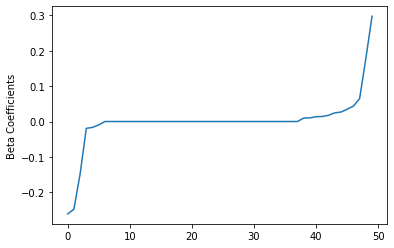

In [21]:
# Beta coefficients
my_dpi = 96
beta = np.sort(lrm.coefficients)
pyplot.plot(beta)
pyplot.ylabel('Beta Coefficients')
pyplot.savefig('Logistic_Baseline_US_betaCoef.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

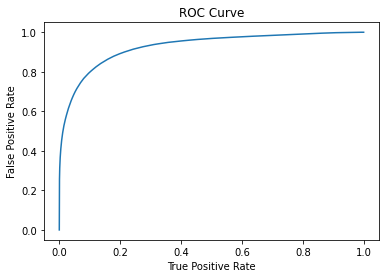

Training set areaUnderROC: 0.9270268300011577


In [22]:
# ROC Curve
trainingSummary = lrm.summary
roc = trainingSummary.roc.toPandas()
pyplot.plot(roc['FPR'],roc['TPR'])
pyplot.ylabel('False Positive Rate')
pyplot.xlabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.savefig('Logistic_Baseline_US_ROC.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

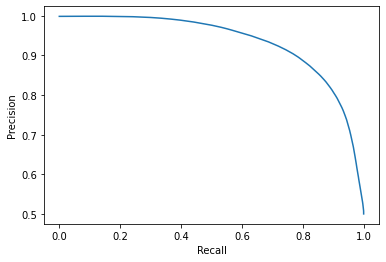

In [23]:
# Precision Recall Curve
pr = trainingSummary.pr.toPandas()
pyplot.plot(pr['recall'],pr['precision'])
pyplot.ylabel('Precision')
pyplot.xlabel('Recall')
pyplot.savefig('Logistic_Baseline_US_RecallPrecision.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

In [24]:
#####################################################################################
############################# Linear SVM  ###########################################
#####################################################################################

In [25]:
# Set up Linear SVM pipeline
lsvc = LinearSVC(maxIter=1000, \
                 regParam=0.1, \
                 featuresCol="scaledFeatures", \
                 labelCol=labelCol)

pipeline_lsvc = Pipeline(stages=[vecAssembler, stdScaler, lsvc])
pipelineModel_lsvc = pipeline_lsvc.fit(trainDF)

In [26]:
# Predict on model
predDF_lsvc = pipelineModel_lsvc.transform(testDF)

In [27]:
# Accuracy and Test Error
lsvc_accuracy = evaluator.evaluate(predDF_lsvc)
print("Accuracy of LogisticRegression is = %g"%(lsvc_accuracy))
print("Test Error of LogisticRegression = %g "%(1.0 - lsvc_accuracy))

Accuracy of LogisticRegression is = 0.937897
Test Error of LogisticRegression = 0.0621033 


In [28]:
# Extract info from pipeline
lsvc = pipelineModel_lsvc.stages[-1]

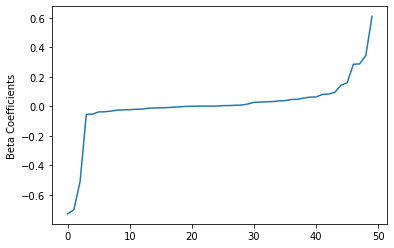

In [29]:
# Beta coefficients
beta = np.sort(lsvc.coefficients)
pyplot.plot(beta)
pyplot.ylabel('Beta Coefficients')
pyplot.savefig('LinearSVC_Baseline_US_betaCoef.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

In [30]:
#####################################################################################
############################# Naive Bayes ###########################################
#####################################################################################

In [31]:
# Set up Naive Bayes pipeline
nb = NaiveBayes(smoothing=1.0, \
                modelType="gaussian", \
                featuresCol="scaledFeatures", \
                labelCol=labelCol)

pipeline_nb = Pipeline(stages=[vecAssembler, stdScaler, nb])
pipelineModel_nb = pipeline_nb.fit(trainDF)

In [32]:
# Predict on model
predDF_nb = pipelineModel_nb.transform(testDF)

In [33]:
# Accuracy and Test Error
nb_accuracy = evaluator.evaluate(predDF_nb)
print("Accuracy of Naïve Bayes is = %g"%(nb_accuracy))
print("Error of Naïve Bayes is = %g "%(1.0 - nb_accuracy))

Accuracy of Naïve Bayes is = 0.938262
Error of Naïve Bayes is = 0.061738 


In [34]:
#######################################################################################
############################# Decision Tree ###########################################
#######################################################################################

In [35]:
# Set up DecisionTree pipeline
dt = DecisionTreeClassifier(labelCol=labelCol, \
                            featuresCol="scaledFeatures", \
                            impurity="gini")

pipeline_dt = Pipeline(stages=[vecAssembler, stdScaler, dt])
pipelineModel_dt = pipeline_dt.fit(trainDF)

In [36]:
# Predict on model
predDF_dt = pipelineModel_dt.transform(testDF)

In [37]:
# Accuracy and Test Error
dt_accuracy = evaluator.evaluate(predDF_dt)
print("Accuracy of Decision Tree is = %g"%(dt_accuracy))
print("Error of Decision Tree is = %g "%(1.0 - dt_accuracy))

Accuracy of Decision Tree is = 0.906096
Error of Decision Tree is = 0.0939041 


In [38]:
#######################################################################################
############################# Random Forest ###########################################
#######################################################################################

In [39]:
# Set up RandomForest pipeline
rf = RandomForestClassifier(labelCol=labelCol, \
                            featuresCol="scaledFeatures", \
                            numTrees=50)

pipeline_rf = Pipeline(stages=[vecAssembler, stdScaler, rf])
pipelineModel_rf = pipeline_rf.fit(trainDF)

In [40]:
# Predict on model
predDF_rf = pipelineModel_rf.transform(testDF)

In [41]:
# Accuracy and Test Error
rf_accuracy = evaluator.evaluate(predDF_rf)
print("Accuracy of Random Tree is = %g"%(rf_accuracy))
print("Error of Random Tree is = %g "%(1.0 - rf_accuracy))

Accuracy of Random Tree is = 0.912071
Error of Random Tree is = 0.0879292 


In [42]:
# Extract info from pipeline
rf = pipelineModel_rf.stages[-1]

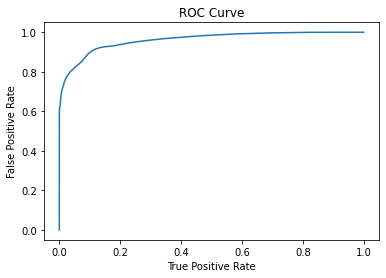

Training set areaUnderROC: 0.9612386843004744


In [43]:
# ROC Curve
trainingSummary = rf.summary
roc = trainingSummary.roc.toPandas()
pyplot.plot(roc['FPR'],roc['TPR'])
pyplot.ylabel('False Positive Rate')
pyplot.xlabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.savefig('RF_Baseline_US_ROC.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

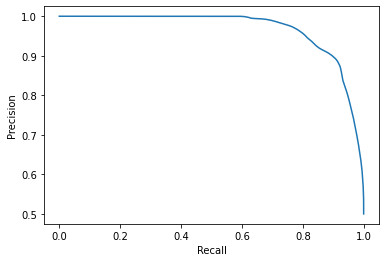

In [44]:
# Precision Recall Curve
pr = trainingSummary.pr.toPandas()
pyplot.plot(pr['recall'],pr['precision'])
pyplot.ylabel('Precision')
pyplot.xlabel('Recall')
pyplot.savefig('RF_Baseline_US_RecallPrecision.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

In [45]:
###############################################################################################
############################# Gradient Boosted Tree ###########################################
###############################################################################################

In [46]:
# Set up GBT pipeline
gbt = GBTClassifier(labelCol=labelCol, \
                    featuresCol="scaledFeatures", \
                    maxIter=10)

pipeline_gbt = Pipeline(stages=[vecAssembler, stdScaler, gbt])
pipelineModel_gbt = pipeline_gbt.fit(trainDF)

In [47]:
# Predict on model
predDF_gbt = pipelineModel_gbt.transform(testDF)

In [48]:
# Accuracy and Test Error
gbt_accuracy = evaluator.evaluate(predDF_gbt)
print("Accuracy of Gradient-Boosted Tree is = %g"%(gbt_accuracy))
print("Error of Gradient-Boosted Tree is = %g "%(1.0 - gbt_accuracy))

Accuracy of Gradient-Boosted Tree is = 0.942322
Error of Gradient-Boosted Tree is = 0.0576776 


In [49]:
###############################################################################
######################## 2. Split over upsampling with SMOTE  #################
###############################################################################

In [50]:
trainDF = spark.read.csv("trainDF_SMOTE.csv", header=True, inferSchema=True)
trainDF.printSchema()
testDF = spark.read.csv("testDF_SMOTE.csv", header=True, inferSchema=True)
labelCol = "loan_status"

root
 |-- loan_amnt: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- collections_12_mths_ex_med: double (nullable = true)
 |-- acc_open_past_24mths: double (nullable = true)
 |-- bc_open_to_buy: double (nullable = true)
 |-- chargeoff_within_12_mths: double (nullable = true)
 |-- delinq_amnt: double (nullable = true)
 |-- mths_since_recent_bc: double (nullable = true)
 |-- num_bc_sats: double (nullable = true)
 |-- num_bc_tl: double (nullable = true)
 |-- num_sats: double (nullable = true)
 |--

In [51]:
#####################################################################################
############################# Logistic Regression  ##################################
#####################################################################################

In [52]:
# Set up logistic regression pipeline
lr = LogisticRegression(maxIter=1000, \
                        regParam=0.3, \
                        elasticNetParam=0.1, \
                        featuresCol="scaledFeatures", \
                        family = "binomial", \
                        labelCol=labelCol)

pipeline_lr = Pipeline(stages=[vecAssembler, stdScaler, lr])
pipelineModel_lr = pipeline_lr.fit(trainDF)

In [53]:
# Predict on model
predDF_lr = pipelineModel_lr.transform(testDF)

In [54]:
evaluator = MulticlassClassificationEvaluator( \
                  labelCol=labelCol, \
                  predictionCol="prediction", \
                  metricName="accuracy")

In [55]:
# Accuracy and Test Error
lr_accuracy = evaluator.evaluate(predDF_lr)
print("Accuracy of LogisticRegression is = %g"%(lr_accuracy))
print("Test Error of LogisticRegression = %g "%(1.0 - lr_accuracy))

Accuracy of LogisticRegression is = 0.869839
Test Error of LogisticRegression = 0.130161 


In [56]:
# Extract info from pipeline
lrm = pipelineModel_lr.stages[-1]

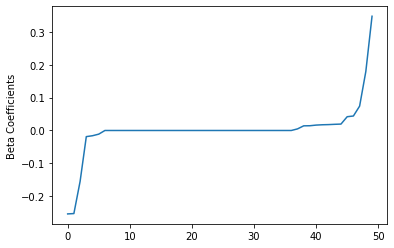

In [57]:
# Beta coefficients
beta = np.sort(lrm.coefficients)
pyplot.plot(beta)
pyplot.ylabel('Beta Coefficients')
pyplot.savefig('Logistic_Baseline_SMOTE_betaCoef.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

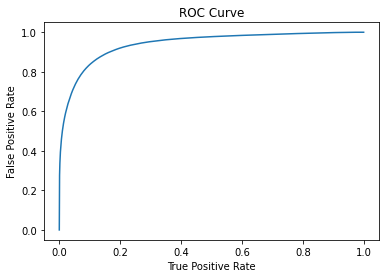

Training set areaUnderROC: 0.9403697643263388


In [58]:
# ROC Curve
trainingSummary = lrm.summary
roc = trainingSummary.roc.toPandas()
pyplot.plot(roc['FPR'],roc['TPR'])
pyplot.ylabel('False Positive Rate')
pyplot.xlabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.savefig('Logistic_Baseline_SMOTE_ROC.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

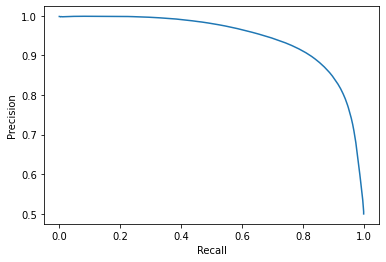

In [59]:
# Precision Recall Curve
pr = trainingSummary.pr.toPandas()
pyplot.plot(pr['recall'],pr['precision'])
pyplot.ylabel('Precision')
pyplot.xlabel('Recall')
pyplot.savefig('Logistic_Baseline_SMOTE_RecallPrecision.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

In [60]:
#####################################################################################
############################# Linear SVM  ###########################################
#####################################################################################

In [61]:
# Set up Linear SVM pipeline
lsvc = LinearSVC(maxIter=1000, \
                 regParam=0.1, \
                 featuresCol="scaledFeatures", \
                 labelCol=labelCol)
                
pipeline_lsvc = Pipeline(stages=[vecAssembler, stdScaler, lsvc])
pipelineModel_lsvc = pipeline_lsvc.fit(trainDF)

In [62]:
# Predict on model
predDF_lsvc = pipelineModel_lsvc.transform(testDF)

In [63]:
# Accuracy and Test Error
lsvc_accuracy = evaluator.evaluate(predDF_lsvc)
print("Accuracy of LogisticRegression is = %g"%(lsvc_accuracy))
print("Test Error of LogisticRegression = %g "%(1.0 - lsvc_accuracy))

Accuracy of LogisticRegression is = 0.941902
Test Error of LogisticRegression = 0.0580984 


In [64]:
# Extract info from pipeline
lsvc = pipelineModel_lsvc.stages[-1]

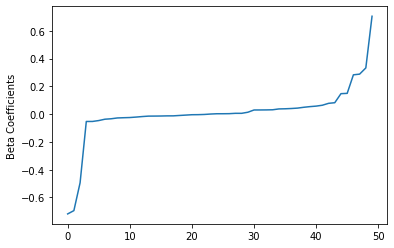

In [65]:
# Beta coefficients
beta = np.sort(lsvc.coefficients)
pyplot.plot(beta)
pyplot.ylabel('Beta Coefficients')
pyplot.savefig('LinearSVC_Baseline_SMOTE_betaCoef.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

In [66]:
#####################################################################################
############################# Naive Bayes ###########################################
#####################################################################################

In [67]:
# Set up Naive Bayes pipeline
nb = NaiveBayes(smoothing=1.0, \
                modelType="gaussian", \
                featuresCol="scaledFeatures", \
                labelCol=labelCol)

pipeline_nb = Pipeline(stages=[vecAssembler, stdScaler, nb])
pipelineModel_nb = pipeline_nb.fit(trainDF)

In [68]:
# Predict on model
predDF_nb = pipelineModel_nb.transform(testDF)

In [69]:
# Accuracy and Test Error
nb_accuracy = evaluator.evaluate(predDF_nb)
print("Accuracy of Naïve Bayes is = %g"%(nb_accuracy))
print("Error of Naïve Bayes is = %g "%(1.0 - nb_accuracy))

Accuracy of Naïve Bayes is = 0.9442
Error of Naïve Bayes is = 0.0558 


In [70]:
#######################################################################################
############################# Decision Tree ###########################################
#######################################################################################

In [71]:
# Set up DecisionTree pipeline
dt = DecisionTreeClassifier(labelCol=labelCol, \
                            featuresCol="scaledFeatures", \
                            impurity="gini")

pipeline_dt = Pipeline(stages=[vecAssembler, stdScaler, dt])
pipelineModel_dt = pipeline_dt.fit(trainDF)

In [72]:
# Predict on model
predDF_dt = pipelineModel_dt.transform(testDF)

In [73]:
# Accuracy and Test Error
dt_accuracy = evaluator.evaluate(predDF_dt)
print("Accuracy of Decision Tree is = %g"%(dt_accuracy))
print("Error of Decision Tree is = %g "%(1.0 - dt_accuracy))

Accuracy of Decision Tree is = 0.946496
Error of Decision Tree is = 0.0535039 


In [74]:
#######################################################################################
############################# Random Forest ###########################################
#######################################################################################

In [75]:
# Set up RandomForest pipeline
rf = RandomForestClassifier(labelCol=labelCol, \
                            featuresCol="scaledFeatures", \
                            numTrees=50)

pipeline_rf = Pipeline(stages=[vecAssembler, stdScaler, rf])
pipelineModel_rf = pipeline_rf.fit(trainDF)

In [76]:
# Predict on model
predDF_rf = pipelineModel_rf.transform(testDF)

In [77]:
# Accuracy and Test Error
rf_accuracy = evaluator.evaluate(predDF_rf)
print("Accuracy of Random Tree is = %g"%(rf_accuracy))
print("Error of Random Tree is = %g "%(1.0 - rf_accuracy))

Accuracy of Random Tree is = 0.950136
Error of Random Tree is = 0.0498644 


In [78]:
# Extract info from pipeline
rf = pipelineModel_rf.stages[-1]

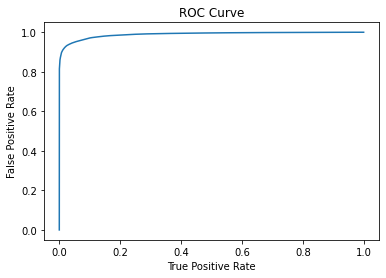

Training set areaUnderROC: 0.9894934938454565


In [79]:
# ROC Curve
trainingSummary = rf.summary
roc = trainingSummary.roc.toPandas()
pyplot.plot(roc['FPR'],roc['TPR'])
pyplot.ylabel('False Positive Rate')
pyplot.xlabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.savefig('RF_Baseline_SMOTE_ROC.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

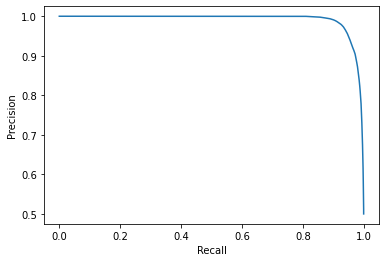

In [80]:
# Precision Recall Curve
pr = trainingSummary.pr.toPandas()
pyplot.plot(pr['recall'],pr['precision'])
pyplot.ylabel('Precision')
pyplot.xlabel('Recall')
pyplot.savefig('RF_Baseline_SMOTE_RecallPrecision.png', dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

In [81]:
###############################################################################################
############################# Gradient Boosted Tree ###########################################
###############################################################################################

In [82]:
# Set up GBT pipeline
gbt = GBTClassifier(labelCol=labelCol, \
                    featuresCol="scaledFeatures", \
                    maxIter=10)

pipeline_gbt = Pipeline(stages=[vecAssembler, stdScaler, gbt])
pipelineModel_gbt = pipeline_gbt.fit(trainDF)

In [83]:
# Predict on model
predDF_gbt = pipelineModel_gbt.transform(testDF)

In [84]:
# Accuracy and Test Error
gbt_accuracy = evaluator.evaluate(predDF_gbt)
print("Accuracy of Gradient-Boosted Tree is = %g"%(gbt_accuracy))
print("Error of Gradient-Boosted Tree is = %g "%(1.0 - gbt_accuracy))

Accuracy of Gradient-Boosted Tree is = 0.96357
Error of Gradient-Boosted Tree is = 0.03643 
